# **Análise de Dados de uma plataforma de E-Commerce**

O principal objetivo da análise de Dados é possibilitar acesso interativo aos dados, permitindo  sua manipulação e oferecendo a analistas e tomadores de decisão a capacidade de conduzir análises apropriadas. 

Com a análise de dados, situações e desempenhos, obtêm-se vislumbres valiosos para a tomada de decisões de maneira mais embasada e assertiva. Tal processo se baseia na transformação de dados em informações, depois em decisões, finalizando-se em ações.

Para esse projeto, será utilizada uma base de dados transacional de um E-commerce. Cada registro apresenta um item de determinado pedido. Dados originalmente de: https://archive.ics.uci.edu/ml/datasets/online%2Bretail

Etapas:


1.   Configuração do ambiente
2.   Obtenção e organização dos dados
3.   Segmentando os clientes (Análise de Agrupamento - *Cluster*/ *Unsupervised learning*)
4.   Análise de cesta de mercado (Market Basket Analysis)

Também foi realizada uma dashboard para acesso interativo aos dados: https://datastudio.google.com/reporting/0a10920d-faf6-4a36-ad01-979ebeb66595

Apresentação em Slides (Complementar): https://drive.google.com/file/d/19Qw8HDEWnTMRnup83zpnoXBZJz84Vjvf/view?usp=sharing



# **1. Configurando o ambiente e os pacotes a serem utilizados**

Carregando os pacotes com funcionalidades específicas para cada ferramental da análise.

In [ ]:
#Carregando os pacotes a serem utilizados
library("tidyverse")
library("dendextend")
library("factoextra")
library("cluster")
library("kableExtra")
library("arules")
library("arulesViz")

In [ ]:
#Configurando algumas opções: digits = 2 para mostra os números em no máximo duas casas decimais; scipen = 999 números não serão exibidos em notação científica
options(digits = 2, scipen = 999)

# **2. Obtendo e Organizado os dados**

### **2.1 - Introdução**

O objetivo dessa análise é de extender uma base de dados transacional - com registros representando itens de deteminado pedido - para outras bases de modo a transformar os dados para cada análise que possa ser interessante para o negócio.

A extensão dessa base em outras permite a extração de novas informações que anteriormente não estavam disponíveis. As múltiplas bases são capazes de trazer insights valiosos para cada olhar de análise do negócio.

A base original de transações permite-se ter noções dos padrões de consumo granulares do cliente. Sua agregação na base de clientes, traz consigo a perda dessas informações granulares, mas ganha ao adicionar à informação referente ao padrão geral dos consumidores, não disponível anteriormente; o mesmo argumento vale para a base dos produtos e dos pedidos.

### **2.2 - Etapas**

Métodos para o agrupamento, agregação e modificação de variáveis permitem de maneira fácil a manipulação dos dados.

Nesse processo, ajusta-se as variáveis até que elas fiquem em um formato agradável para análise e contenham as informações necessárias. 

O tratamento dos dados também se faz presente nessa etapa; algumas inconsistências surgidas de erros devem ser corrigidas para não trazer resultados inconsistentes na análise.

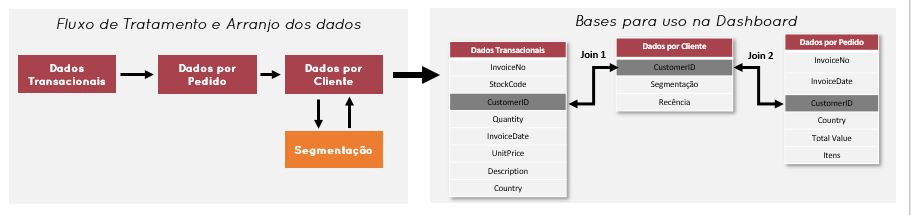

In [ ]:
# Lendo os dados de um arquivo excel(xlsx)
transactions_retail <- read_excel("commerce_data.xlsx", 
                               col_types = c("text", "text", "text", 
                                             "numeric", "date", "numeric", "text", 
                                             "text"))

In [ ]:
# Criando uma nova tabela. mutate é uma função para manipular e criar variáveis; drop_na para remover registros vazios e filter para filtrar apenas os valores positivos
# e que não tenham aqueles códigos determinados
transactions_retail <- transactions_retail %>% mutate(Value = Quantity * UnitPrice) %>%
  drop_na() %>% filter(Value > 0 & !StockCode %in% c("POST","M","D","CRUK","C2"))

In [ ]:
# Agregação 1: transformando os dados transacionais em dados referentes aos pedidos
# group_by agrupará os objetos e a função auxiliar summarise agregará os dados segundo métricas de interesse
# TotalValue = valor total do pedido; Ntransactions: número de transações/itens diferentes contidos no pedido
invoices_retail <- transactions_retail %>% 
  group_by(InvoiceNo, InvoiceDate, CustomerID, Country) %>% 
  summarise(TotalValue = sum(Value), NTransactions = n())

`summarise()` has grouped output by 'InvoiceNo', 'InvoiceDate', 'CustomerID'. You can override using the `.groups` argument.



O objetivo dessa agregação é de gerar informações gerais a respeito das transações.

In [ ]:
# Agregação 2: agregando os dados referentes aos pedidos e transformando-os para obter informações referentes aos clientes para posterior análise
customers_retail <- invoices_retail %>%
  group_by(CustomerID) %>% #Mesmo ID comprou de diferentes paises,
  # Deve se olhar para o cliente ja que ele pode transitar entre paises,
  # a otica da localizacao deve ser por invoice
  summarise(NInvoices = n(), TotalValue = sum(TotalValue), TotalTransactions = sum(NTransactions),
            NLocations = n_distinct(Country),RecentDate = format(max(InvoiceDate))) %>%
  mutate(MultipleLocations = ifelse(NLocations > 1, 1, 0),
         AvgValuePerInvoice = TotalValue/NInvoices,
         AvgValuePerTransaction = TotalValue/TotalTransactions,
         DaysLastInvoice = as.Date("2017-12-07") - as.Date(RecentDate))

customers_retail$DaysLastInvoice <- as.numeric(customers_retail$DaysLastInvoice)

Com essa agregação, perde-se as informações granulares à respeito dos clientes (produtos, datas, valor específicos), mas obtêm-se informações gerais a respeito do comportamento dos clientes. Tais dados posteriormente serão utilizados para a segmentação dos mesmos

In [ ]:
# Agregação 3: agregando os dados transacionais para obter informações à respeito dos produtos
# Para agregação foi utilizado somente o StockCode, já que pela 'description'(nome dos itens) tem-se diferentes nomes para um mesmo código
products_retail <- transactions_retail %>% group_by(StockCode) %>%
summarise(Ninvoices = n_distinct(InvoiceNo), TotalValue = sum(Value),Nlocations = n_distinct(Country),
RecentDate = format(max(InvoiceDate))) %>% mutate(DaysLastInvoice = as.Date("2017-12-07") - as.Date(RecentDate),
AvgValue = TotalValue/Ninvoices, propValue = TotalValue/sum(TotalValue), propInvoices = Ninvoices/sum(Ninvoices))

products_retail$DaysLastInvoice <- as.numeric(products_retail$DaysLastInvoice)

Argumento semelhante ao utilizado anteriormente. Perde-se granularidade(data, clientes que mais consumiram) para obter-se uma visão geral sobre os produtos.

# **3. Segmentando os clientes**

### **3.1 - Introdução**

A segmentação dos clientes é de extrema importância para os negócios, para que os mesmos possam reconhecer personas/tipos em seus clientes e com isso possam direcionar suas ações de maneira assertiva para cada grupo de cliente.

Para que isso possa ser realizado é necessário o conhecimento de características(variáveis) desses clientes. Perfis demográficos e de consumo são extensamente utilizados. Para nossa análise, utilizaremos a base agregada de clientes, com informações à respeito de seus hábitos de consumo.

### **3.2 - Explicações sobre a técnica** [1]

Essa técnica é extensamente utilizada quando há a intenção de verificar a existência de comportamentos semelhantes entre observações. Seu principal objetivo é a alocação de observações em uma quantidade relativamente pequena de agrupamentos homogêneos internamente e heterogêneos entre si e que representem o comportamento conjuntos das observações a partir de determinadas variáveis.

As técnicas de agrupamento são técnicas exploratórias, sem caráter preditivo e/ou inferencial. O analista deve partir da definição dos objetivos, escolher determinada medida de distância(ou semelhança para dados binários) e, então,
escolher determinado método de aglomeração - são os métodos hierárquicos (**clusterização hierárquica**) e não hierárquicos (**kmeans**).

O método não é generalizável, uma vez que a inclusão de novas observações na amostra torna necessária a reaplicação da modelagem, para que sejam gerados novos agrupamentos. Em um ambiente com mudanças muito dinâmicas, talvez seja necessária a sucessiva aplicação dessas modelagens, que podem se tornar insustentáveis devido às suas incessantes mudanças. 

Para contornar esse problema, recorre-se a um novo método de segmentação baseado na **Recência, Frequência e Valor**. Foram determinadas categorias aos clientes com base nos valores assumidos pelas variáveis. Os valores para determinação de tais classes foi feito utilizando a distribuição das variáveis (quantis).

######[1] Fonte: Manual de Análise de Dados. Autores: Luiz Paulo Fávero e Patrícia Belfiore. Elsevier Editora, 2017

### **3.3 Segmentação dos clientes - Alternativa 1: Métodos de Agrupamento (Unsupervised Learning)**


Os resultados obtidos por meio dos esquemas de aglomeração hierárquicos e não hierárquicos podem ser comparadas, e a reaplicação da técnica é uma possibilidade caso se julgue necessário.

Os procedimentos hierárquicos permitem a identificação do ordenamento e da alocação das observações, oferecendo possibilidades para que o analista escolha a quantidade de agrupamentos formados. Nos procedimentos não hierárquicos parte-se de um número conhecido de clusters e então são alocadas as observações nesses grupos.

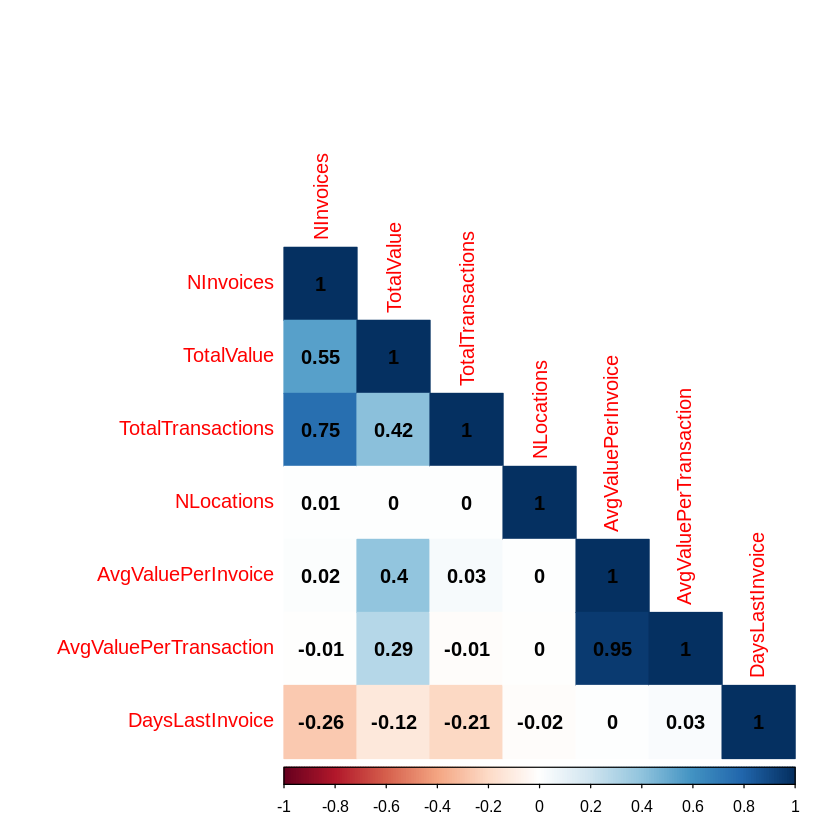

In [ ]:
# Correlação entre as variáveis dos clientes
customers_retail %>% select(-c(1,6,7)) %>% cor() %>% corrplot::corrplot(method = "color",
                                                                      type = "lower",addCoef.col = "black")

In [ ]:
# Selecionando as variáveis a serem utilizadas para o agrupamento, fazendo a padronização por Z-score e calculando a distância euclidiana
dist_customers <- customers_retail %>% select(-c(1,6,7)) %>% scale() %>%
  dist(method = "euclidean")

A medida de distância escolhida foi a euclidiana, por ser a mais básica e amplamente utilizada. Como as variáveis estão em escalas diferentes (valores, dias, etc.) torna-se necessária a padronização dos dados para que as mesmas fiquem na mesma escala.

In [ ]:
# Função para encontrar o método hierárquico com o melhor resultado esperado através da correlação cofonética
clustering_hierarquical <- function(distancia, method){
  hc_customers <- hclust(distancia, method = method)
  coph_customers <- cophenetic(hc_customers)
  cor(dist_customers, coph_customers)
}

metodos <- list("ward.D","ward.D2","single","complete","average","mcquitty","median",
                "centroid")

lapply(metodos, clustering_hierarquical, distancia = dist_customers)

[[1]]
[1] 0.19

[[2]]
[1] 0.37

[[3]]
[1] 0.9

[[4]]
[1] 0.94

[[5]]
[1] 0.98

[[6]]
[1] 0.88

[[7]]
[1] 0.7

[[8]]
[1] 0.95

Foi realizado uma função para que obtenha e calcule o coeficiente cofenético dos diferentes métodos hierárquicos possíveis, para encontrar aquele que melhor performa. Pelos resultados, tal método é o de encadeamento médio (average linkage) na quinta linha. O coeficiente cofenético é utilizado para avaliar a consistência do padrão dos métodos hierárquicos, com valores próximos a 1 indicando a melhor representação. 

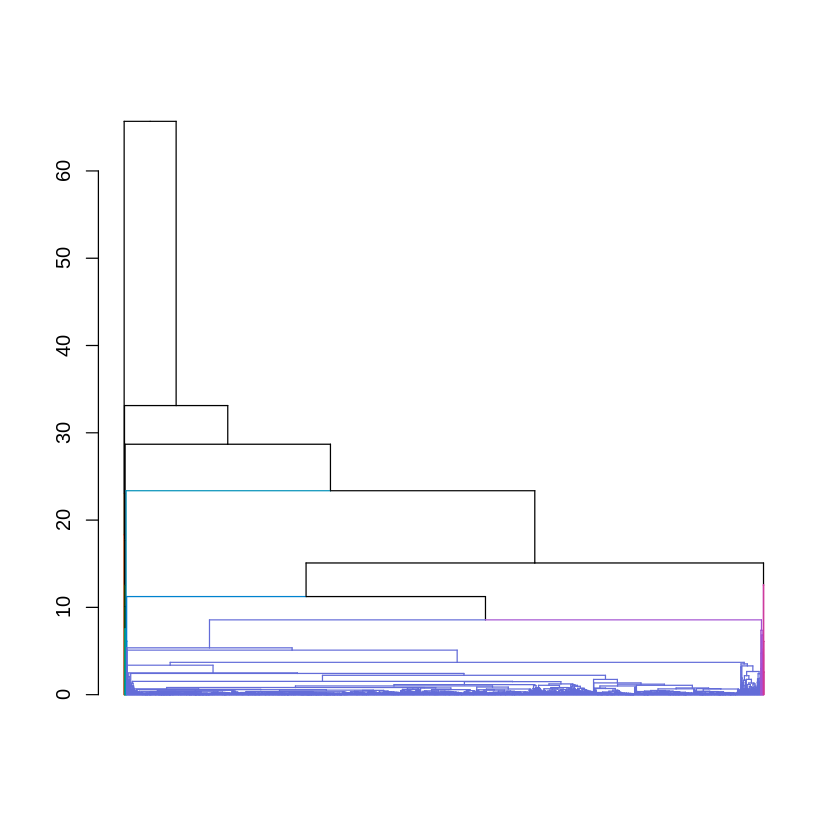

In [ ]:
# Realizando o agrupamento através do método hierárquico
hc_customers <- hclust(dist_customers, method = "average")

# Plotando um dendograma para visualização do processo
hc_customers %>% as.dendrogram() %>% color_branches(k = 15) %>% plot(leaflab = "none")

O dendrograma acima é uma visualização dos passos realizados pelo método para o estabelecimento das classes. Nota-se que os valores individuais nas linhas inferiores vão se unindo e formando os agrupamentos.

Como a amostragem é grande, a leitura da visualização é dificultada. Claramente nota-se a presença de valores discrepantes nas laterais do gráfico. Essa é uma técnica suscetível a valores discrepantes. A manutenção desses valores fica a criterio do pesquisador. No nosso caso, como tais clientes são muito expressivos para o negócio (posteriormente na análise), eles foram mantidos.

In [ ]:
# Extraindo o número de clusters desejados. A critério do analista
cluster_assignments <- cutree(hc_customers, k = 3)

# Rotulando os clientes com base no resultado obtido
customers_retail <- customers_retail %>% mutate(cluster_hc = cluster_assignments)

O número de clusters escolhidos foi de 3, para simplificação.

In [ ]:
# Sumarisando Os agrupamentos/clusters obtidos com base em suas métricas

#Avg = Média
#Sum = Soma
#Count = contagem
customers_retail %>% group_by(cluster_hc) %>%
  select(-c(1,6)) %>%
  summarise(Count = n(),
            AvgNInvoice = round(mean(NInvoices), digits = 0),
            TotalValue = sum(TotalValue),
            AvgNTransactions = round(mean(TotalTransactions),digits = 0),
            AvgValueInvoice = mean(AvgValuePerInvoice),
            AvgValueTransaction = mean(AvgValuePerTransaction),
            AvgLastInvoice = mean(DaysLastInvoice)) %>%
  mutate(Prop = Count/sum(Count)) %>% 
  arrange(desc(Prop)) %>% select(1,2,9,3:8)

cluster_hc,Count,Prop,AvgNInvoice,TotalValue,AvgNTransactions,AvgValueInvoice,AvgValueTransaction,AvgLastInvoice
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,4329,0.99862,4,8252756,86,379,37,92.3
3,4,0.00092,136,274726,5780,1252,12,1.5
1,2,0.00046,2,245656,2,80710,66671,162.5


Pela sumarização dos Agrupamentos, nota-se claramente a presença dos valores discrepantes (agrupamentos 1 e 3). Conclusões:

**O agrupamento 2 é o dos "clientes gerais"** - Respondem à maioria avassaladora dos clientes(99%), tem uma média baixa de pedidos (4), o número de itens pedidos durante a trajetória do cliente é de cerca de (86) itens, seu valor médio é de (379) e eles não compram em cerca de (92) dias. Provavelmente pessoas físicas que fazem compras quando acham oportunidades interessantes.

**O agrupamento 3 é o dos "clientes especiais"** - São apenas 4 clientes, que fazem muitas compras (136), pedem muitos itens na sua trajetória (5780), seu valor médio é de (1252) e compram recorrentemente (1,5) dias. Clientes fiéis, o E-commerce funciona como um abastecedor para os mesmos.

**O agrupamento 1 é um "caso especial"** - são apenas 2 clientes, que fazem poucas compras (2), pedem poucos itens na sua trajetória (2), com valor médio Gigantesco (80710) e não pedem há muito tempo (162,5) dias. Provavelmente algumas redes de revenda de itens que compraram expressivas quantidades em datas específicas.

### **3.3.2 - Clusterização não hierárquica - Kmeans**


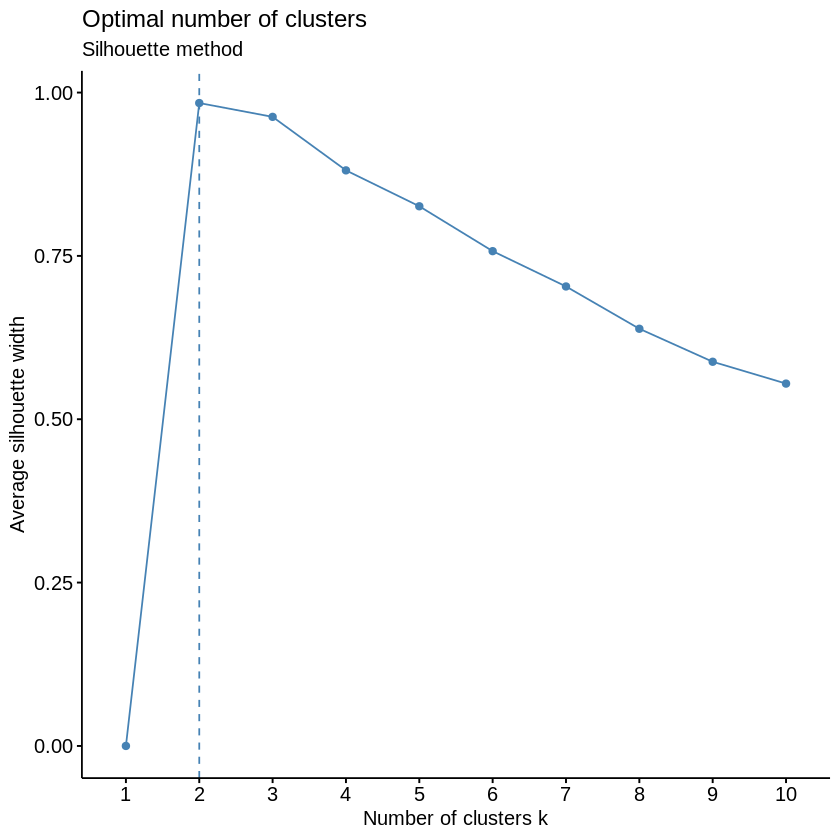

Warning message:
“did not converge in 10 iterations”


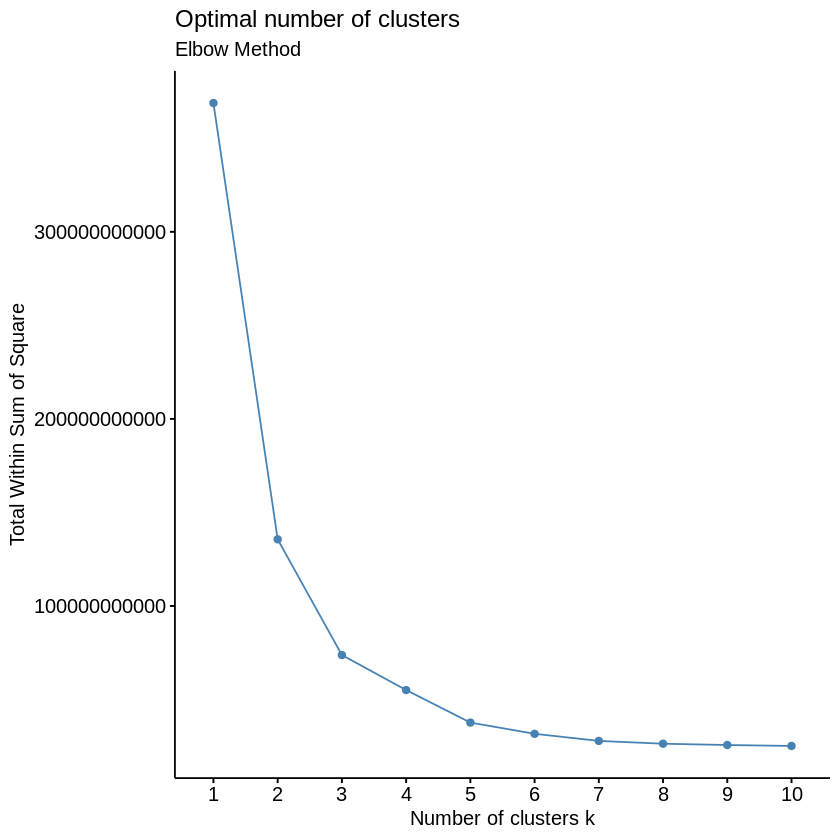

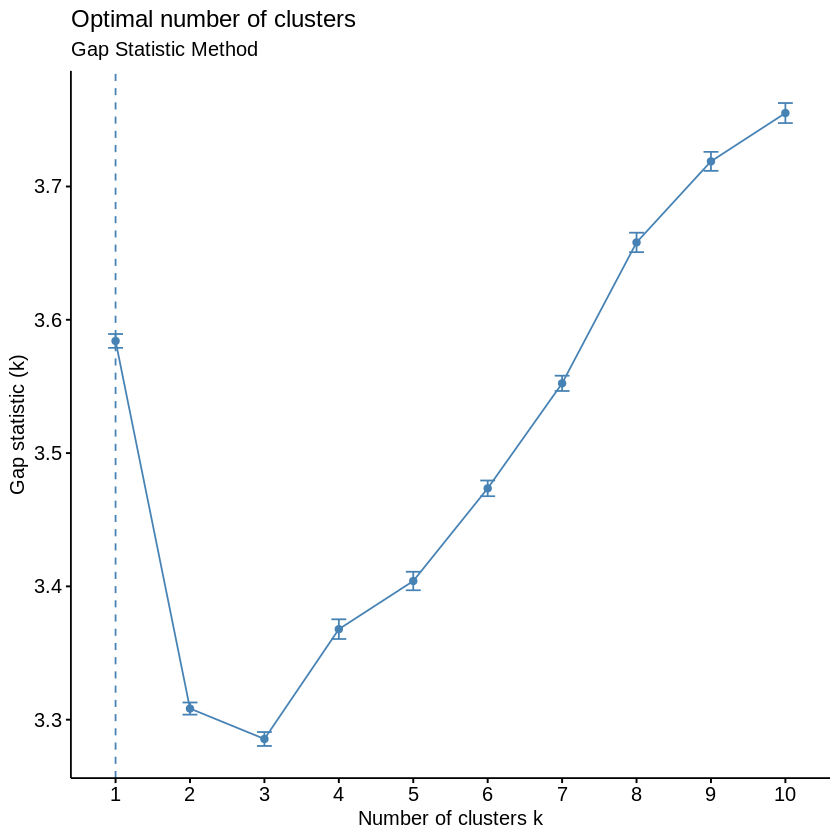

In [ ]:
# Utilizando medidas para a obtençao do número ideal de clusters/agrupamentos
fviz_nbclust(customers_retail[,-c(1,6,7)], kmeans, method = "silhouette") + labs(subtitle = "Silhouette method")# método 1 - silhouette
fviz_nbclust(customers_retail[,-c(1,6,7)], kmeans, method = "wss") + labs(subtitle = "Elbow Method")# método 2 - wss

set.seed(154) #método 3 - gap statistic
fviz_nbclust(customers_retail[,-c(1,6,7)], kmeans, method = "gap_stat", nboot = 50) + labs(subtitle = "Gap Statistic Method")



Para o método não hierárquico Kmeans deve-se avaliar a quantidade de agrupamentos antes da realização da técnica. Foram utilizadas as métricas WSS, Silhouette e Gap. Embora tenha sido recomendado pela maioria das técnicas a utilização de poucos clusters, foram escolhidos 10 para uma análise alternativa da anterior.

In [ ]:
#Realizando a clusterização pelo método de Kmeans
kmeans_customers <- kmeans(dist_customers, centers = 10) # o recomendado foi apenas 1 cluster, mas rodar o código múltiplas vezes pode trazer resultados diferentes
# utilizando 10 apenas para exibição da técnica e dos resultados 

In [ ]:
# Rotulando os clientes com base no método
customers_retail <- customers_retail %>% mutate(cluster_km = kmeans_customers$cluster)

In [ ]:
# Sumarisando os clusters com base em suas variáveis. As mesmas apresentadas anteriormente elaboradas para o método hierárquico
customers_retail %>% group_by(cluster_km) %>%
  select(-c(1,6)) %>%
  summarise(Count = n(),
            AvgNInvoice = round(mean(NInvoices), digits = 0),
            TotalValue = sum(TotalValue),
            AvgNTransactions = round(mean(TotalTransactions),digits = 0),
            AvgValueInvoice = mean(AvgValuePerInvoice),
            AvgValueTransaction = mean(AvgValuePerTransaction),
            AvgLastInvoice = mean(DaysLastInvoice)) %>%
  mutate(Prop = Count/sum(Count)) %>% 
  arrange(desc(Prop)) %>% select(1,2,9,3:8)

cluster_km,Count,Prop,AvgNInvoice,TotalValue,AvgNTransactions,AvgValueInvoice,AvgValueTransaction,AvgLastInvoice
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,1547,0.3569,3,1652895,67,321,24,23
4,911,0.2101,2,645375,38,354,28,76
7,495,0.1142,2,316147,36,315,33,164
2,441,0.1017,9,1612682,215,478,31,20
8,416,0.0960,1,181288,24,312,33,250
9,291,0.0671,1,123220,24,331,62,335
3,150,0.0346,16,1140826,378,772,70,15
10,48,0.0111,27,803498,565,931,79,18
1,19,0.0044,50,1020909,920,2697,1056,28


Com esses número de clusters escolhidos pode-se observar que as distinções entre alguns grupos não são claramente definidas. Pelo gráfico abaixo, nota-se a dificuldade para distinguir os grupos.

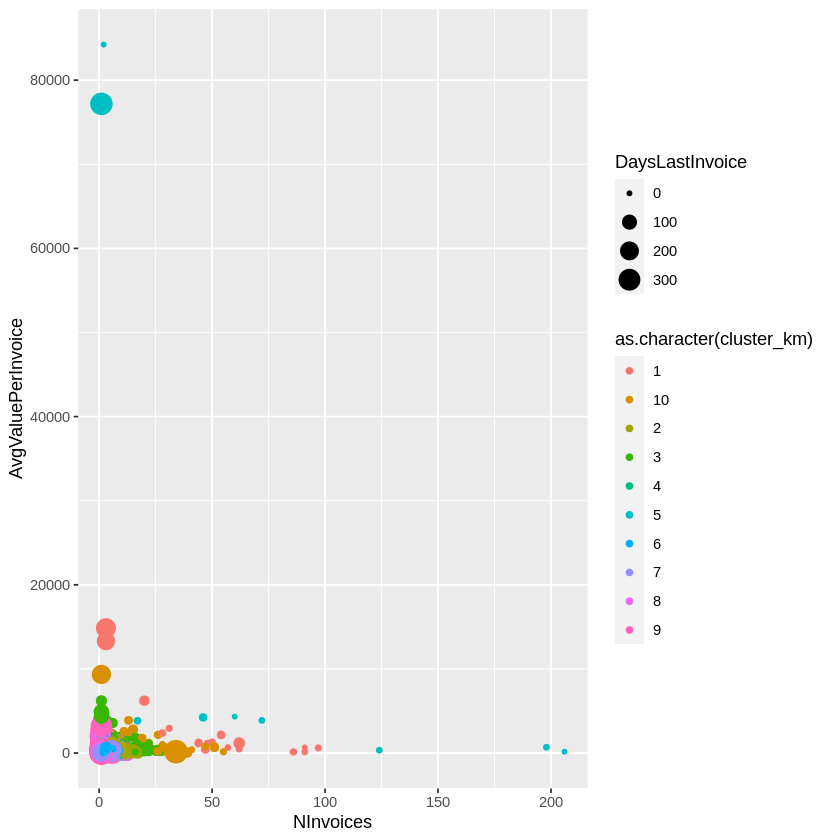

In [ ]:
# Visualização para Relacionar o Valor médio por pedido(eixo y - vertical) e o número de pedidos (eixo x - horizontal) e o número de dias desde a última compra (tamanho da esfera)
ggplot(customers_retail) +
  aes(
    x = NInvoices,
    y = AvgValuePerInvoice,
    colour = as.character(cluster_km),
    size = DaysLastInvoice
  ) +
  geom_point(shape = "circle") +
  scale_color_hue(direction = 1) +
  theme_gray()

### **3.4 - Segmentando os clientes: alternativa 2 - Recência, Frequência e Valor**

Como já mencionado, os métodos de agrupamento necessitam de reaplicação quando da inclusão de novos registros e variáveis. Para contornar esse problema, pode-se segmentar o cliente com base em variáveis que expressem seu comportamente de compra: Recência, a data da última compra; Frequência, a quantidade de pedidos e; Valor, o valor médio de cada pedido.

Para cada métrica foram estabelecidas classes: Ativo e Inativo para recência; Raro, eventual e frequente para frequência; Baixo, Médio e Alto para valor.

Para o estabelecimento das classes, foi utilizado a distribuição de frequência das variáveis, que pudesser ser divisível pela quantidade de classes. Foram calculados os quantis de 50% para Recência, e quantis de 33% para Frequência e Valor. 

In [ ]:
# Obtendo as estatísticas descritivas das variáveis de interesse
summary(customers_retail[,c(2,8,10)])

# Funções para obter a distribuição de frequência das variáveis através dos quantis de 33%
lapply(customers_retail[,c(2,8)],
       function(x){
         return(quantile(x, seq(0,1,0.33)))
       })

# Obter a distribuição da variável que divide a amostra pela metade
quantile(customers_retail$DaysLastInvoice, seq(0,1,0.5))

   NInvoices   AvgValuePerInvoice DaysLastInvoice
 Min.   :  1   Min.   :    4      Min.   :  0    
 1st Qu.:  1   1st Qu.:  178      1st Qu.: 17    
 Median :  2   Median :  290      Median : 50    
 Mean   :  4   Mean   :  417      Mean   : 92    
 3rd Qu.:  5   3rd Qu.:  425      3rd Qu.:142    
 Max.   :206   Max.   :84236      Max.   :373    

$NInvoices
 0% 33% 66% 99% 
  1   1   4  30 

$AvgValuePerInvoice
    0%    33%    66%    99% 
   3.8  208.1  362.6 2023.7

0%  50% 100% 
   0   50  373

In [ ]:
#Rotulando as variáveis com base nas regras determinadas
customers_retail <- customers_retail %>% mutate(Frequency = ifelse(NInvoices <= 1, "Raro", ifelse(NInvoices > 1 & NInvoices <= 4, "Eventual",ifelse(NInvoices >4, "Frequente", "NA"))),
                                                MonetaryValue = ifelse(AvgValuePerInvoice <= 209, "Baixo", ifelse(AvgValuePerInvoice > 209 & AvgValuePerInvoice <= 363, "Médio",ifelse(AvgValuePerInvoice >363, "Alto","NA"))),
                                                Recency = ifelse(DaysLastInvoice <= 50, "Ativo","Inativo"))       

# **4. Market Basket Analysis**

### **4.1 Introdução**

A principal ideia na análise de cesta de mercado é identificar relações entre produtos que usualmente são comprados em conjunto. Para-se realizar tal análise, torna-se necessária apenas os dados de transações, em que os produtos comprados são tabulados sob uma única instância transacional - no nosso caso, o ID da compra ('InvoiceNo'). A cesta de mercado faz parte do conjunto das regras de associação.

A análise de cesta de mercado auxilia na necessidade de inferir necessidades e preferências dos clientes a partir de seus padrões de consumo. Ela pode ser usada como uma ferramenta para o planejamento de ações como cross-selling, up-selling, melhor organização do espaço físico das lojas, entre muitas outras, que excedem as aplicações de cunho comercial.

### **4.2 Explicações sobre a técnica** [2]

Em bases de dados expressivas, podem-se existir muitas regras e é necessário que se filtre entre aquelas que realmente podem ser úteis e explicativas. Para isso, são utilizados diversos parâmetros para a melhor escolha das associações,
baseados nos itens, sendo X o antecedente, e Y o consequente:

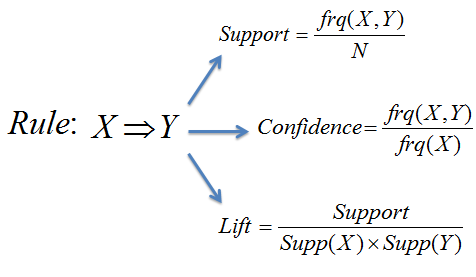

**Support (Suporte):** *Quantidade de vezes que os produtos são comprados conjuntamente em relação ao total de todas as transações da base de dados.*

**Confidence (Confiança):** *Mede o quão frequente itens Y aparecem em transações com o item X. É a proporção de transações que incluem o X(antecedente) e ao mesmo tempo o Y(consequente); trata-se da probabilidade condicional de encontrar o Y em transações em que o X já aparece.*

**Lift (Elevação):** *Mede o quão provável que o item Y será comprado com o item X. Valores maiores que 1 indicam que os itens são muito prováveis de serem comprados conjuntamente. As regras trazem melhores resultados se são maiores que 1.*

Após definidos os parâmetros, o algoritmo mais utilizado nas regras de associação é o Apriori. Quando o  quando apresentado com um conjunto de itens, o algoritmo encontra subconjuntos que sejam comuns a pelo menos um número mínimo da frequência das transações(parâmetro suporte); é empregada uma abordagem de baixo para cima, onde os itens únicos são extendidos e encontrados os demais itens que mais se associam a esse. Para cada iteração, deve-se se respeitar um parâmetro(suporte) mínimo para que tais combinações sejam ainda mais extendidas. O processo termina quando mais nenhuma extensão é possível de ser sucedida.

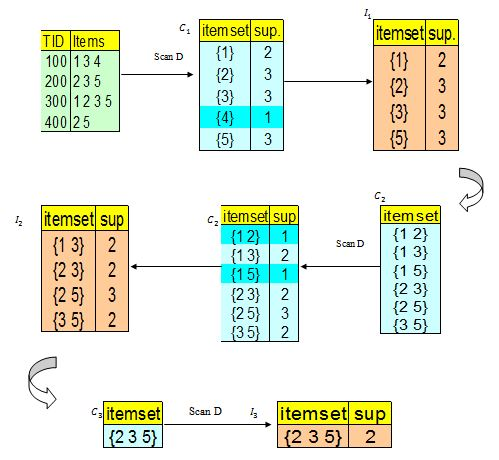

[2] Fonte: Business Intelligence e Análise de Dados para Gestão do Negócio. Autores: Ramesh Sharda, Efraim Turbain, Dursun Delen. Editora Bookman, 2019. 

In [ ]:
# Transformando a base transacional em regras de associação
AggPosData <- split(transactions_retail$StockCode, transactions_retail$InvoiceNo)
Txns <- as(AggPosData, 'transactions')

Warning message in asMethod(object):
“removing duplicated items in transactions”


In [ ]:
# Resumos das transações e itens
Txns

transactions in sparse format with
 18413 transactions (rows) and
 3662 items (columns)

In [ ]:
# A partir das transações, utilizar o algoritmo Apriori para a busca das regras 
Rules <- apriori(Txns, parameter = list(supp=0.01, conf=0.01, target = 'rules',
                                        minlen=2)) #Os parâmetros mínimos desejados são espeficidos pelo analista segundo seus objetivos 

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.01    0.1    1 none FALSE            TRUE       5    0.01      2
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 184 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[3662 item(s), 18413 transaction(s)] done [0.15s].
sorting and recoding items ... [627 item(s)] done [0.01s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 done [0.02s].
writing ... [909 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [ ]:
# Número de regras encontradas
Rules

set of 909 rules 

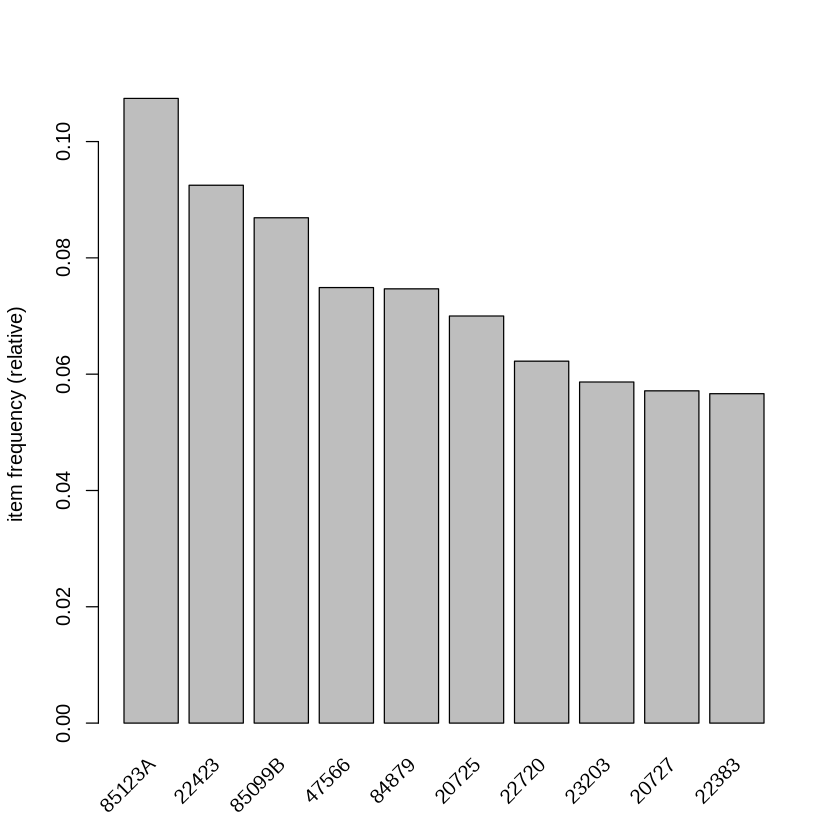

In [ ]:
# Gráficos dos itens mais presentes
itemFrequencyPlot(Txns, topN = 10)

As regras podem ser extraídas e utilizadas em outros meios. Os códigos abaixo permitem uma visualização interativa das regras. (obs: estão como comentários, pois não são funcionais/interativos em formato notebook)


In [ ]:
#plot(Rules, method = "scatter", engine = "htmlwidget", max = 150)#scatterplot


In [ ]:
#plot(Rules, method = "graph", engine = "htmlwidget", max = 50)#grafo

In [ ]:
#plot(Rules, method = "grouped", measure = "lift", shading = "confidence")#agrupado

# **5. Dashboard - E-Commerce**

Como a base de dados é expressiva, tem-se múltiplas possibilidades para análise dos dados. As análise aqui realizadas são de cunho geral e podem ser combinadas posteriormente com novas técnicas.

Uma dessas técnicas é uma dashboard, que permite a visualização interativa com os dados. A dashboard facilita na utilização de filtros, além de possuir aspectos visuais reconfortantes e simplificadores ao leitor. 

Dashboards oferecem exibições visuais de importantes informações consolidadas e organizadas em poucas telas, para que possam ser mais facilmente exploradas e aprofundadas. São construídos com o objetivo de oferecer a tomadores de decisão, uma ideia resumida e precisa do que acontece na organização.

A dashboard foi feita utilizando a ferramenta gratuita do Google, o Data Studio. A dashboard contém 4 páginas e boa parte das ferramentas e bases de dados aqui utilizadas foram adaptadas nela.

Acesso: https://datastudio.google.com/reporting/0a10920d-faf6-4a36-ad01-979ebeb66595